# AlexNet implementation (with PyTorch)
Model from: https://pytorch.org/hub/pytorch_vision_alexnet/

Training loop from: https://kushaj.medium.com/training-alexnet-with-tips-and-checks-on-how-to-train-cnns-practical-cnns-in-pytorch-1-61daa679c74a

## Import required modules

In [72]:
import torch
from torch import nn, optim
from copy import deepcopy
from PIL import Image
from torchvision import transforms
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
netsPath = '../nets/'

cpu


In [73]:
import random
random.seed(1234) # reproducibility seed

## Get model

### Get pretrained model from source

In [74]:
alexnet = torch.load(netsPath + "Alexnet_preTrained.pth")
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Data transformation

Set number of classifications labels

In [75]:
num_labels = 4 # DME, NORMAL
labels_list = ["DME", "NORMAL"]

In [76]:
data_dir = '/volume/OCT/OCT2017/'
sets = ["train", "val", "test"]

In [77]:
import torchvision.transforms as transforms

size = 224 # given by alexnet

transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [116]:
# Load image form given path and convert into RGB mode
def loadImage(path):
    im = Image.open(path)
    if im.mode != "RGB":
        return im.convert("RGB")
    return im

# Load images from path for given labels and apply given transform and split into batches
def loadDataset(data_dir, set_name, labels, transform, batch_size=None):
    images_data = []; labels_data = [];
    # Load data for each given label
    for lab in range(len(labels)):
        path = f"{data_dir}{set_name}/{labels[lab]}/"
        imgs = [transform(loadImage(f"{path}/{ima}")) for ima in os.listdir(path)]
        labs = [lab] * len(imgs)
        images_data.extend(imgs)
        labels_data.extend(labs)
    # Split into batches if desired
    if batch_size:
        ims_size = len(images_data);
        images_batches = []; labels_batches = [];
        # Split into batches and add batch_size images into each
        for batch in range(0, ims_size, batch_size):
            images_batches.append(images_data[batch:batch + batch_size])
            labels_batches.append(labels_data[batch:batch + batch_size])
        return images_batches, labels_batches
    return images_data, torch.tensor(labels_data)

#### Create train and test sets

In [117]:
batch_size = 32 # prefered by alexnet

#trnX, trnY = loadDataset(data_dir, "train", labels_list, transform)
valX, valY = loadDataset(data_dir, "val", labels_list, transform)
tstX, tstY = loadDataset(data_dir, "test", labels_list, transform, batch_size)

Sets shape

In [118]:
#print(f"Train set size: {len(trnY)}")
print(f"Test set size: {len(tstY)}")
print(f"Val set size: {len(valY)}")

Test set size: 16
Val set size: 16


Check labels and images

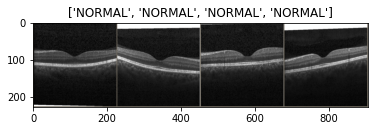

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Our images are normalized so denormalize then and convert them to numpy
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    


images, labels = valX[-4:], valY[-4:]
grid_img = make_grid(images, nrow=4)
imshow(grid_img, title = [labels_list[x] for x in labels[-4:]])

## LIMO model

### Modify architecture

In [124]:
def newAlexNet(num_labels):
    newAlexnet = deepcopy(alexnet)
    lastLayer = newAlexnet.classifier[-1] # get usual last layer
    newAlexnet.classifier[-1] = nn.Linear(lastLayer.in_features, num_labels) # modify last layer number of outputs (labels to be classified)
    return newAlexnet

limoAlexnet = newAlexNet(num_labels)

### Set hiperparameters

In [83]:
learning_rate = 0.001
momentum = 0.9
epochs = 3

### Loss function, optimizer and scheduler

In [125]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(limoAlexnet.parameters(), lr=learning_rate, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

### Train loop

In [11]:
def train(model, data, criterion, optimizer, scheduler = None, num_epochs=100, seed=None):
    n_batches = len(data["train"])
    if epochs > n_batches:
        raise ValueError("Epochs greater than number of batches.")
    batches = [for i in range(n_batches)]
    since = time.time()
    if seed:
        random.seed(seed)
    
    train_batch_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        valBatch = batches.pop(random.randint(a=0, b=len(batches))) # select a random batch as validation
        
        # You perform validation test after every epoch
        for phase in ["train", "val"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0; running_corrects = 0;
            
            for idx, inputs in enumerate(data["train"]):
                if idx == valbatch:
                    continue
                inputs = inputs.to(device)
                labels = 
                labels = labels.to(device)
                
                # zero accumulated gradients
                optimizer.zero_grad()
                
                # During train phase we want to remember history for grads
                # and during val we do not want history of grads
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if idx%200 == 0 or idx == num_batches - 1:
                        train_batch_loss.append(loss.item())
                        print('Epoch {}: {}/{} steps in progress'.format(epoch+1, idx+1, num_batches))
                        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects.double() / len(data_loader[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_epoch_loss.append((epoch_loss, epoch_acc))
                if scheduler:
                    scheduler.step(loss.item())
            else:
                train_epoch_loss.append((epoch_loss, epoch_acc))
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model

### Train model with train set

In [12]:
trainedLimoModel = train(limoAlexnet, data_loader, loss_fn, optimizer, scheduler, epochs, seed=123)

Epoch 1/10
---------------
Epoch 1: 1/2608 steps in progress
Epoch 1: 201/2608 steps in progress
Epoch 1: 401/2608 steps in progress


KeyboardInterrupt: 

Evaluate model over test set

In [ ]:
trainedLimoModel.eval() # set model to be evaluated (ignore grads)
confMatrix = np.zeros((num_labels, num_labels), dtype=int)
trainedLimoModel.eval()
for batchNum, (inputs, labels) in enumerate(data_loader["test"]):
    outputs = trainedLimoModel(inputs)
    _, preds = torch.max(outputs, 1)
    for i, pred in enumerate(preds):
        confMatrix[pred, labels[i]] += 1
        
testAcc = confMatrix.trace() / confMatrix.sum()
print(f'Test set accuracy: {testAcc}')

Confusion matrix

In [ ]:
import seaborn as sns
x_axis_labels = labels_list # labels for x-axis
y_axis_labels = labels_list # labels for y-axis
ax = sns.heatmap(confMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix");

In [ ]:
accLabel = {labels_list[lab]: confMatrix[lab, lab] / sum(confMatrix[:, lab]) for lab in range(num_labels)}
print(f"Acc by label: {accLabel}")

Save model into files (saved models listed in file)

In [ ]:
netVer = len(os.listdir(path))
netType = "alexnet"
netID = "_".join([netType, str(netVer)])
torch.save(trainedLimoModel, netsPath + netID + ".pth")

Load saved model

In [ ]:
model = torch.load(path + netID + ".pth")
model.eval()